## Imports

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Fri Nov 17 12:01:13 2017
@author: abhijeet
"""

import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import os

## Functions

In [0]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate

## Data load and preproccess

In [0]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

num_classes = 10
y_train = keras.utils.to_categorical(y_train,num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)


170500096/170498071 [==============================] - 4s 0us/step


## Model architecture 

In [0]:
weight_decay = 1e-4

inputs = keras.layers.Input(shape=x_train.shape[1:])
block_one = keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay))(inputs)
block_one = keras.layers.Activation('elu')(block_one)
block_one1 = keras.layers.BatchNormalization()(block_one)
block_one = keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay))(block_one1)
block_one = keras.layers.Activation('elu')(block_one)
block_one = keras.layers.BatchNormalization()(block_one)
block_one = keras.layers.MaxPooling2D(pool_size=(2,2))(block_one)
block_one = keras.layers.Dropout(0.2)(block_one)

resize_b1 = keras.layers.MaxPooling2D(pool_size=(2,2))(block_one1)

block_two = keras.layers.concatenate([resize_b1, block_one])
block_two = keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay))(block_two)
block_two = keras.layers.Activation('elu')(block_two)
block_two1 = keras.layers.BatchNormalization()(block_two)
block_two = keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay))(block_two1)
block_two = keras.layers.Activation('elu')(block_two)
block_two = keras.layers.BatchNormalization()(block_two)
block_two = keras.layers.MaxPooling2D(pool_size=(2,2))(block_two)
block_two = keras.layers.Dropout(0.3)(block_two)

resize_b12 = keras.layers.MaxPooling2D(pool_size=(2,2))(resize_b1)
resize_b2 = keras.layers.MaxPooling2D(pool_size=(2,2))(block_two1)

block_three = keras.layers.concatenate([resize_b12, resize_b2, block_two])
block_three = keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay))(block_three)
block_three = keras.layers.Activation('elu')(block_three)
block_three = keras.layers.BatchNormalization()(block_three)
block_three = keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay))(block_three)
block_three = keras.layers.Activation('elu')(block_three)
block_three = keras.layers.BatchNormalization()(block_three)
block_three = keras.layers.MaxPooling2D(pool_size=(2,2))(block_three)
block_three = keras.layers.Dropout(0.4)(block_three)

flat = keras.layers.Flatten()(block_three)
out = keras.layers.Dense(100)(flat)
out = keras.layers.Dense(10, activation='softmax')(out)

model = keras.models.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         activation[0][0]                 
______________________________________________________________________________________________

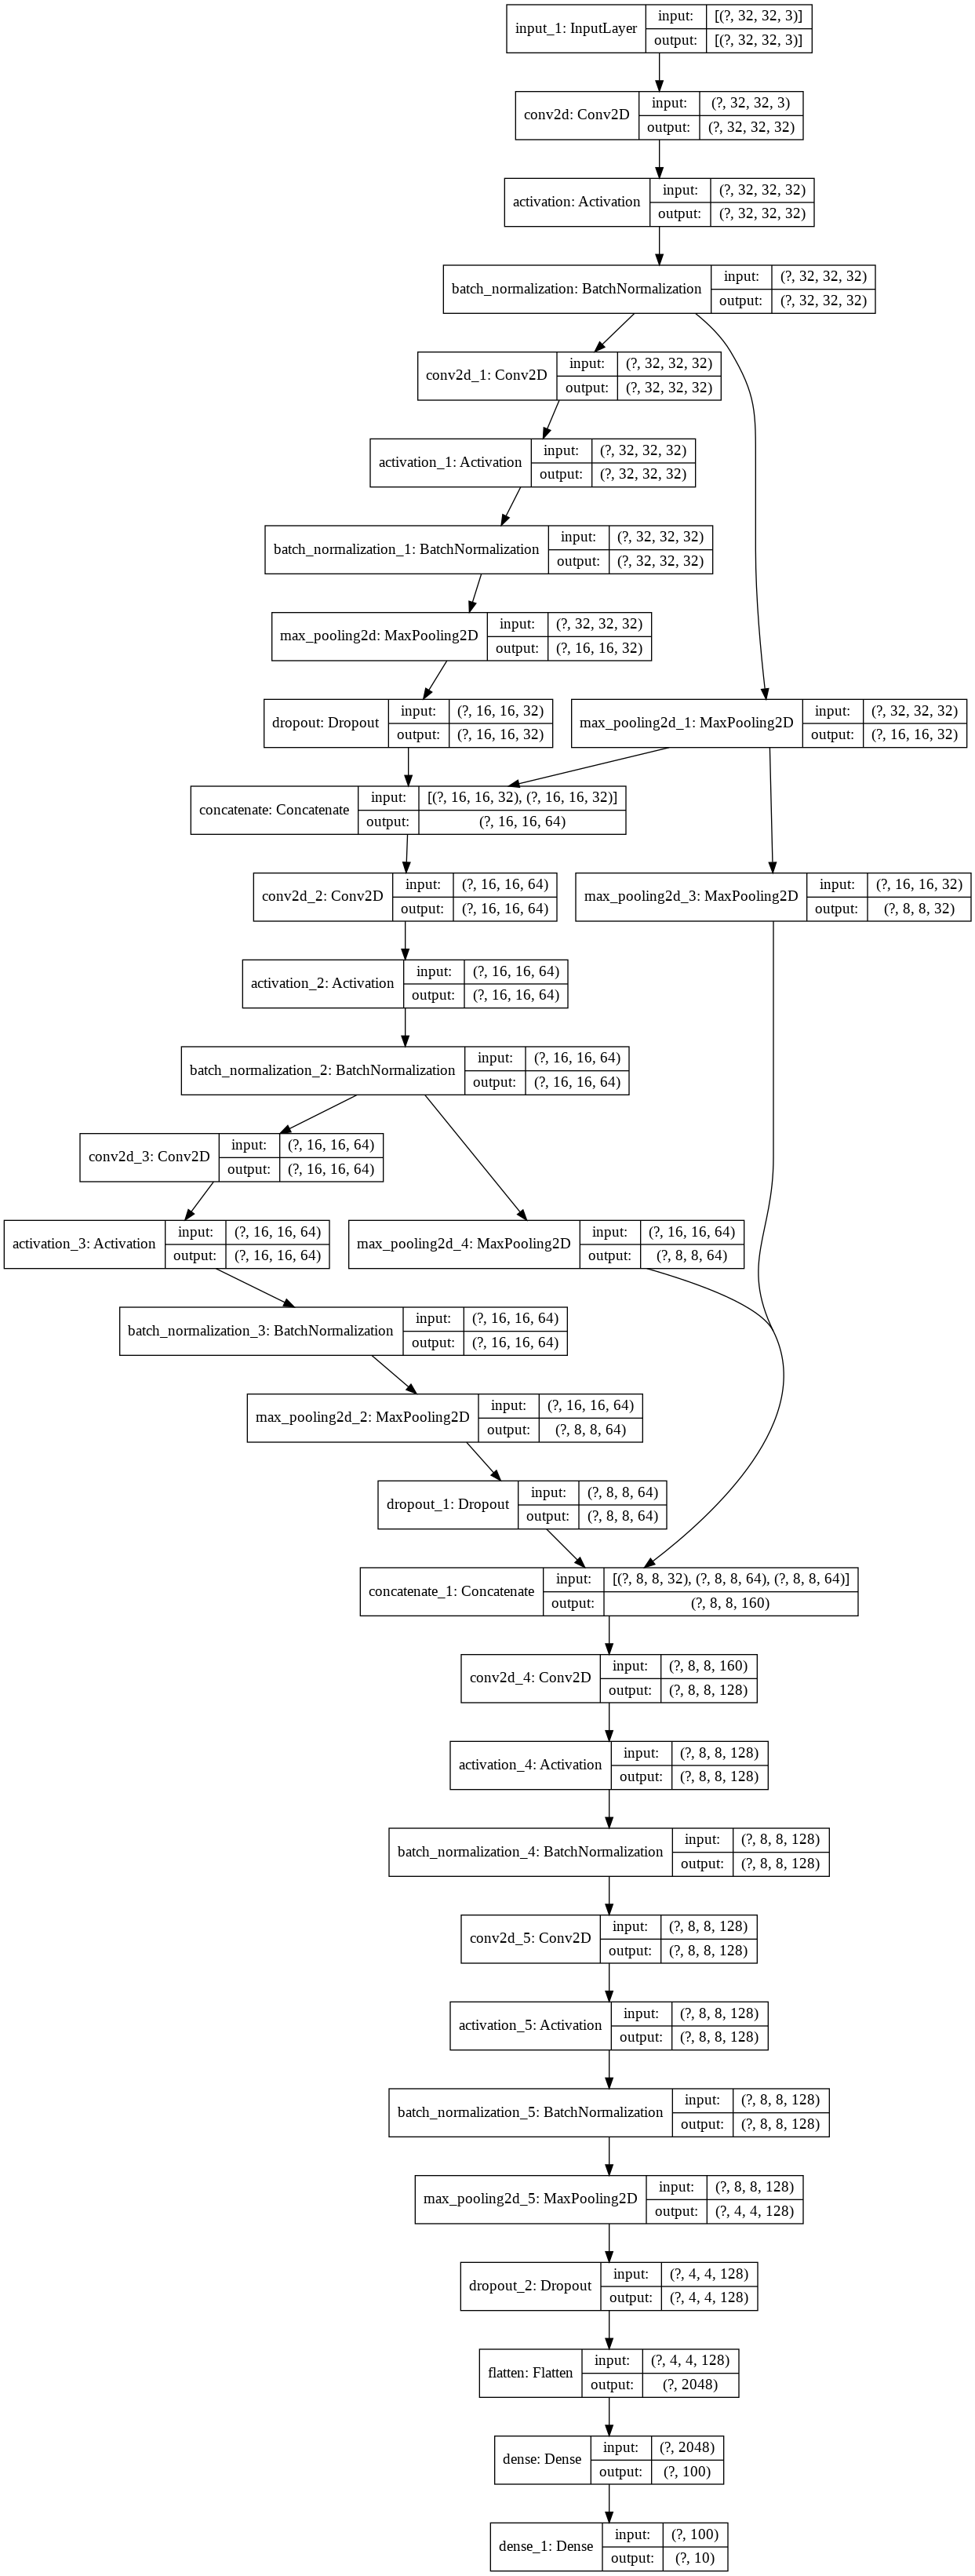

In [0]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

## Data augumentation

In [0]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

## Callbacks

In [0]:
run_path = "/content/drive/My Drive/Colab Notebooks/mgu/model_res4"
mcp_save = keras.callbacks.ModelCheckpoint(os.path.join(run_path, 'model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5'),
                           save_best_only=True, monitor='val_accuracy')
callbacks = [keras.callbacks.LearningRateScheduler(lr_schedule), mcp_save]

## Training

In [0]:
batch_size = 64
opt_rms = keras.optimizers.RMSprop(lr=0.00001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
model.load_weights("/content/drive/My Drive/Colab Notebooks/mgu/model_res4/model-087-0.909344-0.896200.h5")
model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=125,\
                    verbose=1,validation_data=(x_test,y_test), callbacks=callbacks)
#save to disk
model_json = model.to_json()
with open('/content/drive/My Drive/Colab Notebooks/mgu/models/model.json', 'w') as json_file:
    json_file.write(model_json)

Epoch 1/125
781/781 [==============================] - 26s 34ms/step - loss: 0.4925 - accuracy: 0.8826 - val_loss: 0.6887 - val_accuracy: 0.8420 - lr: 0.0010
Epoch 2/125
781/781 [==============================] - 26s 34ms/step - loss: 0.5078 - accuracy: 0.8794 - val_loss: 0.5460 - val_accuracy: 0.8725 - lr: 0.0010
Epoch 3/125
781/781 [==============================] - 27s 34ms/step - loss: 0.5160 - accuracy: 0.8791 - val_loss: 0.5764 - val_accuracy: 0.8658 - lr: 0.0010
Epoch 4/125
781/781 [==============================] - 27s 34ms/step - loss: 0.5232 - accuracy: 0.8805 - val_loss: 0.5970 - val_accuracy: 0.8632 - lr: 0.0010
Epoch 5/125
781/781 [==============================] - 27s 34ms/step - loss: 0.5198 - accuracy: 0.8798 - val_loss: 0.6181 - val_accuracy: 0.8549 - lr: 0.0010
Epoch 6/125
781/781 [==============================] - 27s 34ms/step - loss: 0.5257 - accuracy: 0.8808 - val_loss: 0.6320 - val_accuracy: 0.8629 - lr: 0.0010
Epoch 7/125
781/781 [==============================]

## Testing

In [0]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))